# Experiment Results Analysis & Visualization

This notebook is for analyzing and plotting the results from the multi-treatment causal inference experiments. It contains three main sections:
1.  **Setup and Data Loading**: Imports libraries and parses all individual experiment runs from the `results` directory into a single pandas DataFrame.
2.  **Overall Performance Summary**: Generates a faceted plot comparing the Mean PEHE of all models across all scenarios and levels of treatment overlap (`kappa`).
3.  **Deep Dive into a Single Run**: Provides functions to generate detailed plots (True vs. Estimated CATE and CATE vs. Feature) for a single, specific experiment run of interest.

## 0. Setup and Data Loading

In [1]:
# Best plotting library
#!pip install tueplots

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tueplots import bundles, axes

from tueplots import cycler
from tueplots.constants import markers
from tueplots.constants.color import palettes
from tueplots.constants.color import rgb

plt.rcParams['text.usetex'] = False

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 300})

plt.rcParams.update(cycler.cycler(color=palettes.pn))

from tueplots import figsizes, fonts
plt.rcParams.update(figsizes.icml2022_full())
plt.rcParams.update(fonts.beamer_moml())



In [2]:
def parse_and_load_results(results_dir='results'):
    """
    Walks through the results directory, parses experiment parameters from
    directory names, and loads the PEHE results.
    """
    all_results = []
    
    if not os.path.exists(results_dir):
        print(f"Warning: Results directory '{results_dir}' not found.")
        return pd.DataFrame()
    
    for root, _, files in os.walk(results_dir):
        if 'cate_results.npz' in files:
            try:
                parts = root.replace('\\', '/').split('/')
                scenario, model = parts[-4], parts[-3]
                params = parts[-2].split('_')
                n_samples, kappa = int(params[0].replace('n', '')), float(params[1].replace('k', ''))
                seed = int(parts[-1].replace('seed', ''))
            except (IndexError, ValueError) as e:
                print(f"Could not parse directory name: {root}. Skipping.")
                continue

            result_data = np.load(os.path.join(root, 'cate_results.npz'))
            pehe_scores = result_data['pehe']
            
            all_results.append({
                'scenario': scenario, 'model': model, 'n_samples': n_samples,
                'kappa': kappa, 'seed': seed, 'pehe_t1_vs_t0': pehe_scores[0],
                'pehe_t2_vs_t0': pehe_scores[1], 'pehe_t3_vs_t0': pehe_scores[2]
            })

    if not all_results:
        print("No result files found. Please run the experiments first.")
        return pd.DataFrame()
        
    return pd.DataFrame(all_results)

# Load all the data
results_df = parse_and_load_results()
display(results_df.head())

Could not parse directory name: results/hyperparam_opt. Skipping.


,scenario,model,n_samples,kappa,seed,pehe_t1_vs_t0,pehe_t2_vs_t0,pehe_t3_vs_t0
0,education,causal_forest,2000,0.5,10,2.557117,2.131194,1.517139
1,education,causal_forest,2000,0.5,11,2.711279,2.081294,1.627898
2,education,causal_forest,2000,0.5,12,2.932803,1.938391,1.527871
3,education,causal_forest,2000,0.5,13,2.722684,2.329519,1.612595
4,education,causal_forest,2000,2.0,10,3.599040,3.457493,1.681457


## 1. Quick comparison of the 4 models.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles

def plot_medication_summary(df):
    """
    Generates a focused plot for the medication scenario, forcing non-TeX rendering.
    """
    if df is None or df.empty:
        print("DataFrame is empty. No results to plot.")
        return
    
    pehe_cols = ['pehe_t1_vs_t0', 'pehe_t2_vs_t0', 'pehe_t3_vs_t0']
    df['pehe_avg'] = df[pehe_cols].mean(axis=1)

    model_order = ['structured_mcfr', 'mcfrnet', 'hierarchical_mcfr', 'causal_forest']
    
    # --- THE DEFINITIVE FIX IS HERE ---
    # 1. Get the base ICML style from the bundle
    icml_style = bundles.icml2022(family="sans-serif")
    
    # 2. Explicitly force the 'text.usetex' setting to False within the style itself.
    # This will override the bundle's default and any other conflicting settings.
    icml_style['text.usetex'] = False
    
    # 3. Apply the fully corrected style
    with plt.rc_context(icml_style):
        fig, ax = plt.subplots()
        
        sns.pointplot(
            data=df,
            x='kappa',
            y='pehe_avg',
            hue='model',
            hue_order=model_order,
            dodge=0.1, 
            errorbar=('ci', 95),
            capsize=.1,
            ax=ax
        )
        
        ax.set_xlabel('Overlap Parameter ($\\kappa$)')
        ax.set_ylabel('Mean PEHE')
        ax.set_title('Model Performance on Medication Scenario')
        ax.grid(True)
        ax.legend(title='Model')
        
        plt.tight_layout()
        #plt.savefig('medication_summary_plot.pdf')
        print("Plot saved as 'medication_summary_plot.pdf'")
        plt.show()

In [4]:
#df_all_models_run = results_df[(results_df["seed"]==1) & (results_df["n_samples"]==5000) & (results_df["scenario"]=="education")]
df_all_models_run = results_df[results_df["seed"]==70] # Seed 70 had the 4 baselines

In [5]:
df_all_models_run

,scenario,model,n_samples,kappa,seed,pehe_t1_vs_t0,pehe_t2_vs_t0,pehe_t3_vs_t0
238,education,causal_forest,1000,0.5,70,3.123477,2.693648,1.707507
239,education,causal_forest,1000,2.0,70,3.916045,4.375411,1.978118
240,education,causal_forest,1000,5.0,70,4.344825,4.509903,1.988953
241,education,hierarchical_mcfr,1000,0.5,70,0.826530,0.471459,0.406107
242,education,hierarchical_mcfr,1000,2.0,70,0.987274,1.000523,0.486891
243,education,hierarchical_mcfr,1000,5.0,70,1.255668,1.234180,0.515927
244,education,mcfrnet,1000,0.5,70,0.996007,0.479667,0.382845
245,education,mcfrnet,1000,2.0,70,1.161413,0.580805,0.460110
246,education,mcfrnet,1000,5.0,70,1.216388,1.139893,0.570722
247,education,structured_mcfr,1000,0.5,70,4.633549,4.973589,4.631194


/tmp/ipykernel_57583/61401441.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pehe_avg'] = df[pehe_cols].mean(axis=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans-serif'] not found. F

Plot saved as 'medication_summary_plot.pdf'


findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

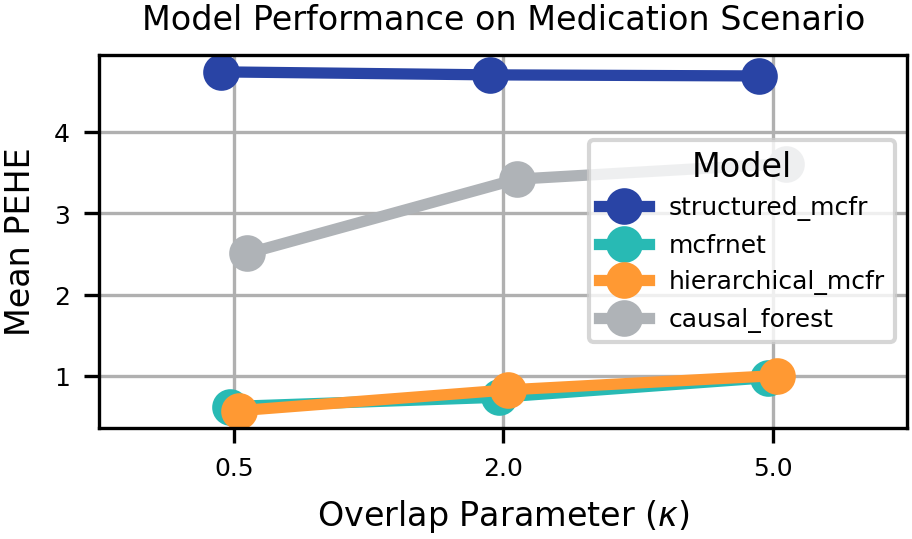

In [6]:
plot_medication_summary(df_all_models_run)

## 2. Overall Performance Summary Plot

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles

def plot_pehe_vs_kappa(df):
    """
    Generates a faceted point plot of Mean PEHE vs. Kappa for all models,
    using a robust, non-LaTeX tueplots style.
    """
    if df is None or df.empty:
        print("DataFrame is empty. No results to plot.")
        return

    # Filter out any failed models for a cleaner plot
    df_plot = df[~df['model'].str.contains('structured')].copy()

    df_long = pd.melt(df_plot, 
                      id_vars=['scenario', 'model', 'kappa'],
                      value_vars=['pehe_t1_vs_t0', 'pehe_t2_vs_t0', 'pehe_t3_vs_t0'],
                      var_name='effect', value_name='pehe')
    df_long['effect'] = df_long['effect'].str.replace('pehe_', '').str.upper()

    # --- THE ROBUST FIX IS HERE ---
    # 1. Get the base style from the bundle
    neurips_style = bundles.neurips2024()
    # 2. Explicitly force the 'text.usetex' setting to False
    neurips_style['text.usetex'] = False

    # 3. Apply the modified style
    with plt.rc_context(neurips_style):
        g = sns.catplot(
            data=df_long,
            x='kappa',
            y='pehe',
            hue='model',
            col='effect',
            row='scenario',
            kind='point',
            dodge=True, 
            errorbar=('ci', 95),
            capsize=.1,
            height=3,
            aspect=1.3,
            sharey=False
        )

        g.figure.suptitle(f'Model Performance (PEHE) vs. Treatment Overlap (Kappa), n={N}', y=1.03)
        g.set_axis_labels('Overlap Parameter ($\\kappa$)', 'Mean PEHE (Lower is Better)')
        g.set_titles(row_template="{row_name} Scenario", col_template="{col_name}")
        g.despine(left=True)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        
        plt.savefig('summary_pehe_vs_kappa.pdf')
        print("Plot saved as 'summary_pehe_vs_kappa.pdf'")
        plt.show()

In [8]:
N = 3000

# We select the seeds from the last simulation round
exp_df = results_df[(results_df["seed"]>109) & (results_df["n_samples"]==N)]
exp_df

,scenario,model,n_samples,kappa,seed,pehe_t1_vs_t0,pehe_t2_vs_t0,pehe_t3_vs_t0
316,education,causal_forest,3000,0.5,110,2.461526,1.921825,1.571622
317,education,causal_forest,3000,0.5,111,2.577259,2.069334,1.552390
318,education,causal_forest,3000,0.5,112,2.451045,1.924322,1.577878
319,education,causal_forest,3000,0.5,113,2.596555,1.822507,1.547282
320,education,causal_forest,3000,0.5,114,2.313189,1.913230,1.615677
...,...,...,...,...,...,...,...,...
1663,medication,mcfrnet,3000,5.0,116,0.255250,0.400591,0.569867
1664,medication,mcfrnet,3000,5.0,117,0.257038,0.448852,0.578581
1665,medication,mcfrnet,3000,5.0,118,0.252800,0.432603,0.564467
1666,medication,mcfrnet,3000,5.0,119,0.268867,0.405456,0.584532


/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Plot saved as 'summary_pehe_vs_kappa.pdf'


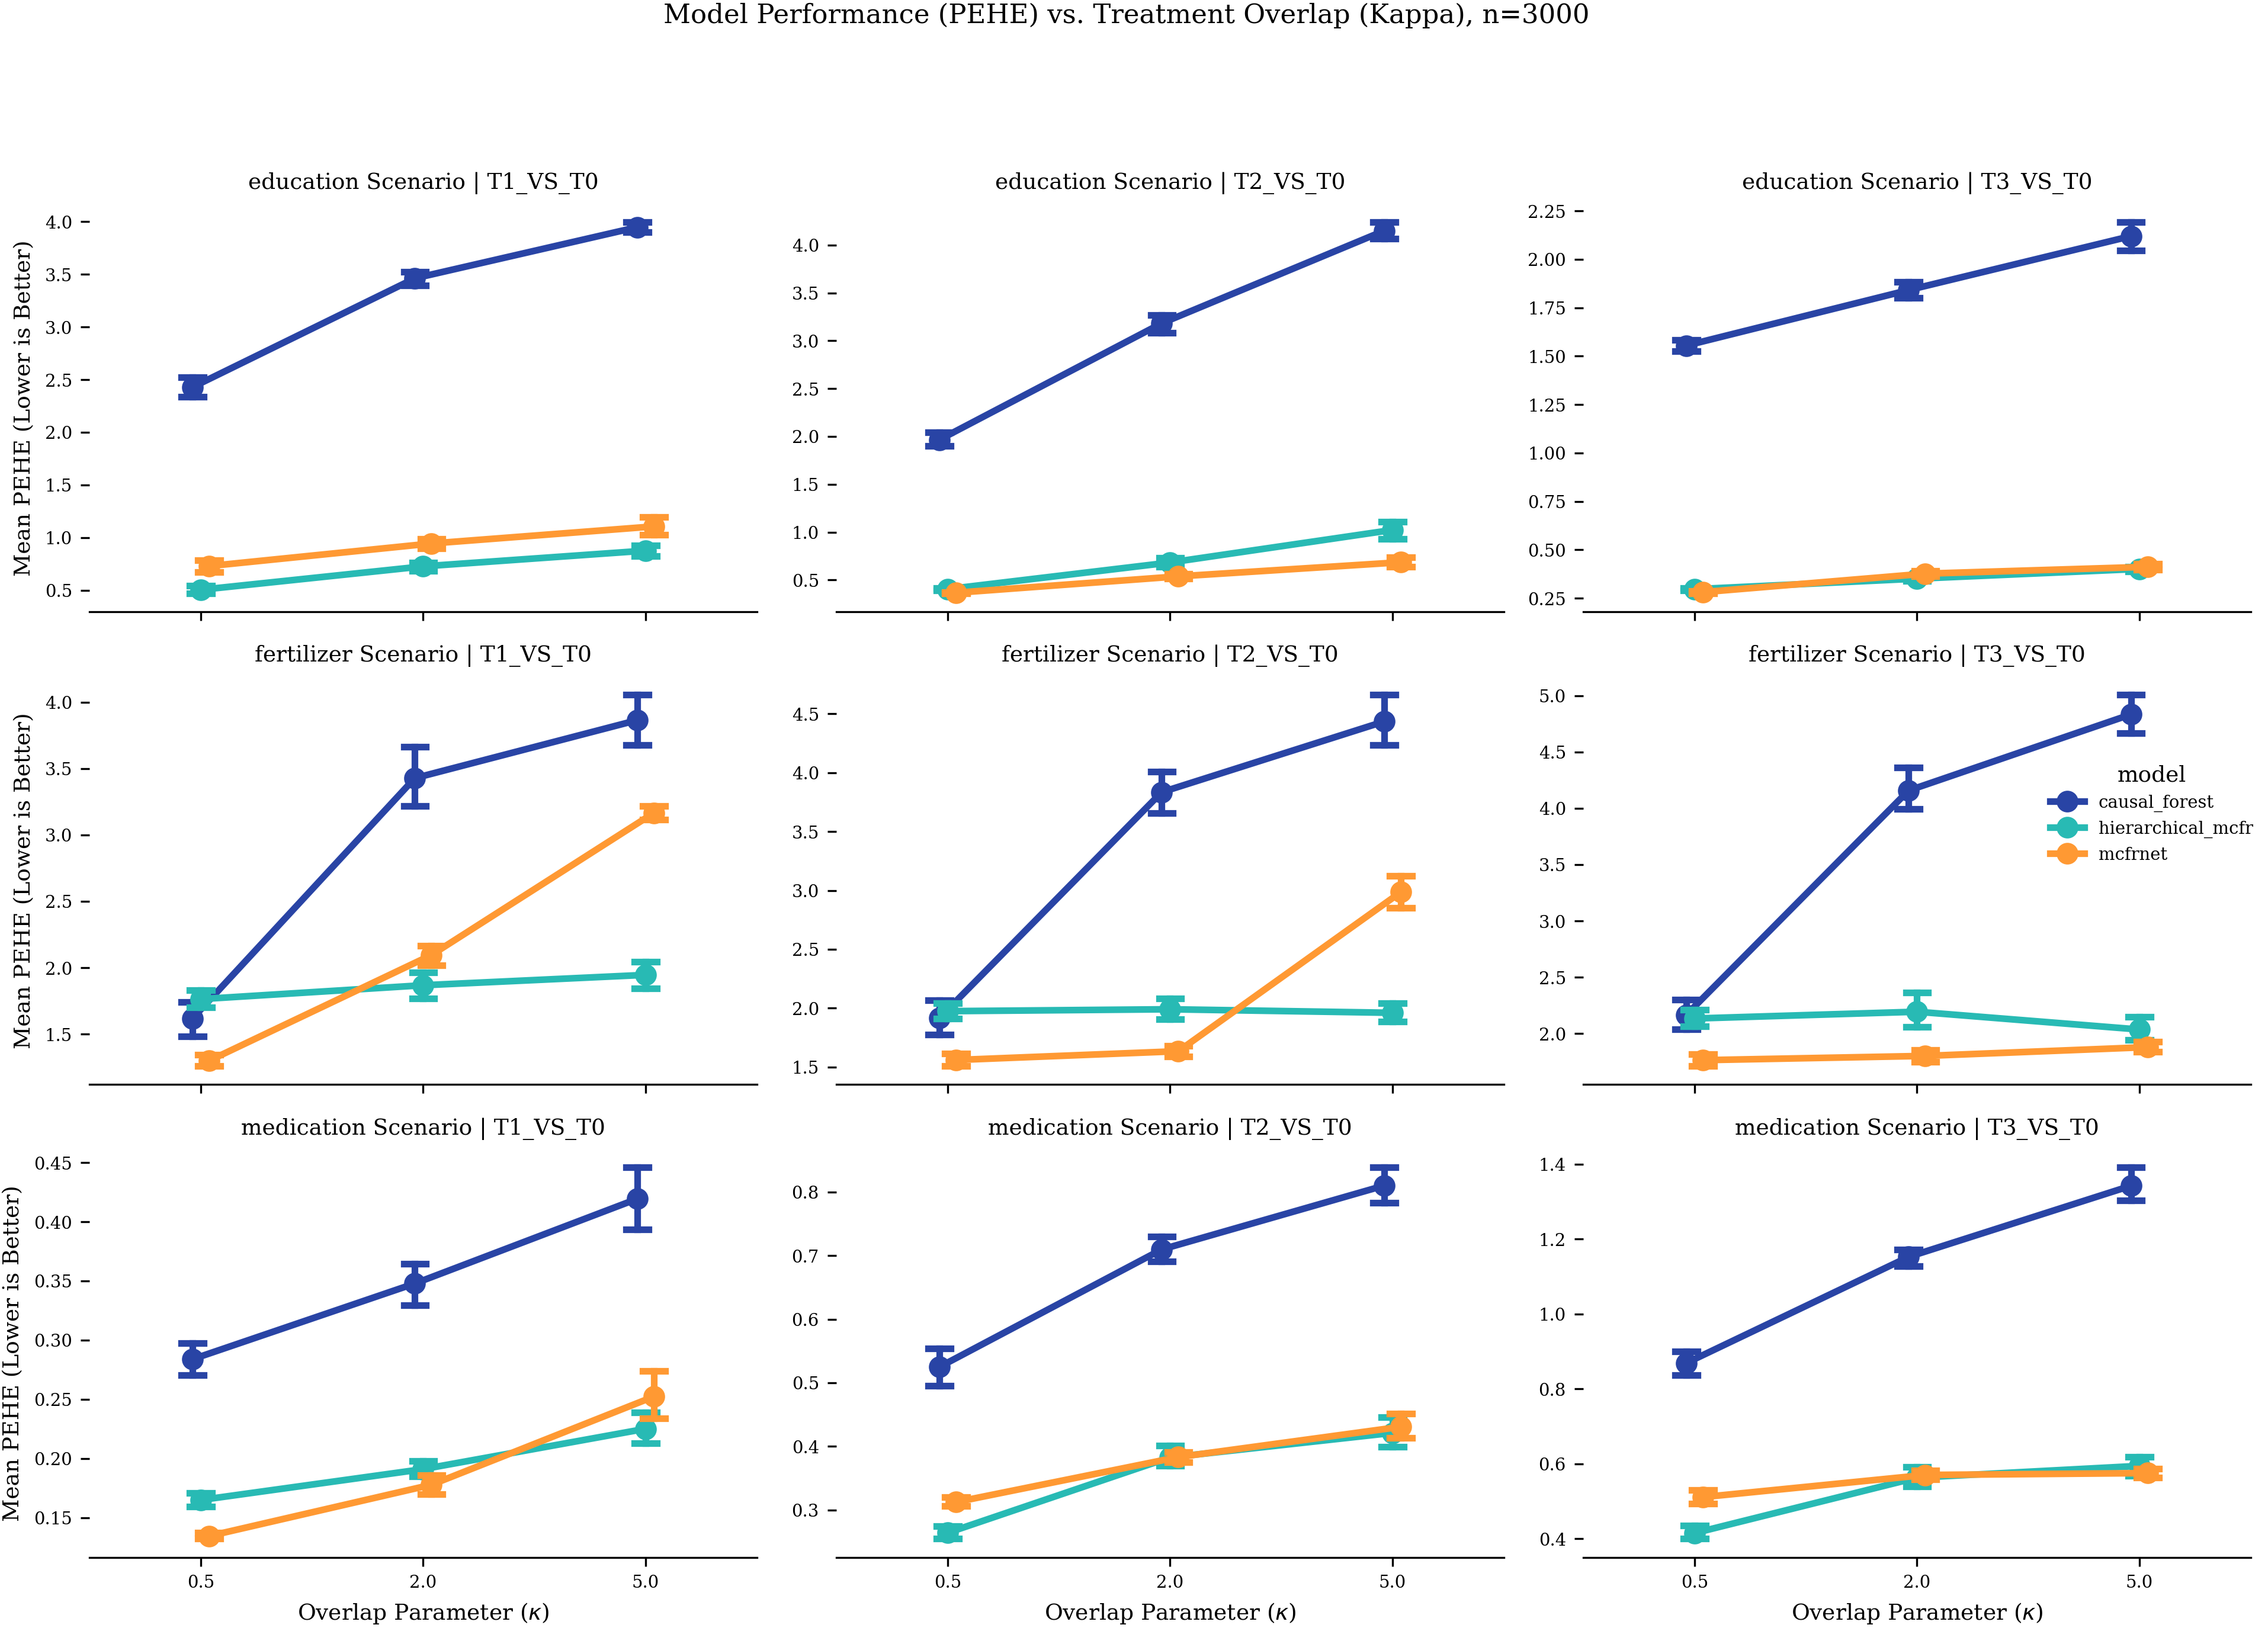

In [9]:
plot_pehe_vs_kappa(exp_df)

### 2.1 Data Aggregate for Latex Table

In [10]:
last_exp_complete = results_df[results_df["seed"]>109]

In [11]:
def aggregate_for_table_with_total(df, n_sizes_to_include):
    """
    Filters results, calculates mean and Standard Error (SE) for individual
    and total PEHE, and formats for the table.
    """
    if df is None or df.empty:
        print("Input DataFrame is empty.")
        return pd.DataFrame()

    # Filter for specific sample sizes first
    filtered_df = df[df['n_samples'].isin(n_sizes_to_include)].copy()
    
    if filtered_df.empty:
        print(f"No results found for n_samples in {n_sizes_to_include}.")
        return pd.DataFrame()

    # --- CORRECTED LOGIC: Calculate Total PEHE on the filtered copy ---
    pehe_cols = ['pehe_t1_vs_t0', 'pehe_t2_vs_t0', 'pehe_t3_vs_t0']
    filtered_df['pehe_total'] = filtered_df[pehe_cols].mean(axis=1)
    
    # Add the new total column to the list for aggregation
    agg_cols = pehe_cols + ['pehe_total']
    
    aggregations = {col: ['mean', stats.sem] for col in agg_cols}
    
    summary = filtered_df.groupby(['scenario', 'model', 'n_samples', 'kappa']).agg(aggregations).reset_index()
    
    summary.columns = ['_'.join(col).strip('_') for col in summary.columns.values]
    
    # Format all columns into 'mean (sem)' strings
    for col in agg_cols:
        summary[col] = summary.apply(
            lambda row: f"{row[col+'_mean']:.2f} ({row[col+'_sem']:.2f})", 
            axis=1
        )
    
    final_cols = ['scenario', 'model', 'n_samples', 'kappa'] + agg_cols
    return summary[final_cols]



# --- How to use the functions ---
# raw_results = parse_and_load_results()
aggregated_data = aggregate_for_table_with_total(last_exp_complete, n_sizes_to_include=[100, 1000, 8000])
# print("Aggregated Results for LaTeX Table:")
# print(aggregated_data)

In [12]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) # Set a large width to prevent line wrapping

aggregated_data.head(80)

,scenario,model,n_samples,kappa,pehe_t1_vs_t0,pehe_t2_vs_t0,pehe_t3_vs_t0,pehe_total
0,education,causal_forest,100,0.5,4.08 (0.15),4.85 (0.29),2.17 (0.18),3.70 (0.11)
1,education,causal_forest,100,2.0,4.58 (0.15),5.05 (0.26),2.59 (0.29),4.08 (0.15)
2,education,causal_forest,100,5.0,4.64 (0.15),4.95 (0.24),2.88 (0.30),4.16 (0.10)
3,education,causal_forest,1000,0.5,3.13 (0.08),2.75 (0.08),1.65 (0.02),2.51 (0.03)
4,education,causal_forest,1000,2.0,3.95 (0.08),4.11 (0.11),1.93 (0.03),3.33 (0.05)
5,education,causal_forest,1000,5.0,4.27 (0.07),4.55 (0.09),2.24 (0.08),3.69 (0.04)
6,education,causal_forest,8000,0.5,1.91 (0.02),1.71 (0.03),1.36 (0.01),1.66 (0.01)
7,education,causal_forest,8000,2.0,3.15 (0.02),2.84 (0.04),1.79 (0.01),2.59 (0.01)
8,education,causal_forest,8000,5.0,3.69 (0.04),3.96 (0.04),2.10 (0.02),3.25 (0.01)
9,education,hierarchical_mcfr,100,0.5,4.32 (0.17),5.09 (0.30),3.88 (0.15),4.43 (0.14)


## 3. Deep Dive into a Single Experiment Run

The plots below are for analyzing a **single** run in more detail. You can change the `EXAMPLE_RUN_PATH` variable to point to any specific `cate_results.npz` file you want to investigate.

In [13]:
def plot_comparison_scatter(run_dir, scenario, n_samples, kappa, seed):
    """
    Generates a side-by-side comparison of True vs. Estimated CATE scatter plots.
    This version uses default tueplots sizing for robustness.
    """
    models_to_plot = ['causal_forest', 'mcfrnet', 'hierarchical_mcfr']
    model_names_pretty = ['Causal Forest', 'MCFRNet (Baseline)', 'Hierarchical-MCFR']
    
    results_data = {}
    
    for model in models_to_plot:
        path = os.path.join(run_dir, scenario, model, f"n{n_samples}_k{kappa}", f"seed{seed}", "cate_results.npz")
        try:
            results_data[model] = np.load(path)
        except FileNotFoundError:
            print(f"Warning: Results file not found for model '{model}' at {path}. Skipping.")
            
    if len(results_data) == 0:
        print("No valid results found for this condition.")
        return

    # --- Define styles ---
    plot_style = bundles.neurips2024()
    plot_style['text.usetex'] = False
    plot_color = rgb.tue_lightgreen

    with plt.rc_context(plot_style):
        # --- FIX: Let tueplots and matplotlib handle the size automatically ---
        # We removed all custom sizing logic.
        fig, axes = plt.subplots(1, len(results_data), sharex=True, sharey=True)
        fig.suptitle(f'True vs. Estimated CATE (T1 vs T0) | {scenario.title()}, n={n_samples}, k={kappa}', y=1.05)

        min_val, max_val = np.inf, -np.inf
        for model in results_data:
            min_val = min(min_val, results_data[model]['true_cate'][:, 0].min(), results_data[model]['est_cate'][:, 0].min())
            max_val = max(max_val, results_data[model]['true_cate'][:, 0].max(), results_data[model]['est_cate'][:, 0].max())
        
        min_val *= 1.1
        max_val *= 1.1

        for i, model in enumerate(results_data.keys()):
            ax = axes[i]
            data = results_data[model]
            true_cate_t1 = data['true_cate'][:, 0]
            est_cate_t1 = data['est_cate'][:, 0]

            ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1.5)
            sns.scatterplot(x=true_cate_t1, y=est_cate_t1, alpha=0.4, s=20, ax=ax, edgecolor=None, color=plot_color)
            
            ax.set_title(model_names_pretty[i])
            ax.set_xlabel("True CATE")
            ax.set_aspect('equal', 'box')
            ax.grid(True)

        axes[0].set_ylabel("Estimated CATE")
        
        # Use a slightly larger bottom margin to prevent labels from overlapping title
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.savefig('cate_comparison_scatter_styled.pdf')
        print("Styled plot saved as 'cate_comparison_scatter_styled.pdf'")
        plt.show()
        

/tmp/ipykernel_57583/4128434119.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])


Styled plot saved as 'cate_comparison_scatter_styled.pdf'


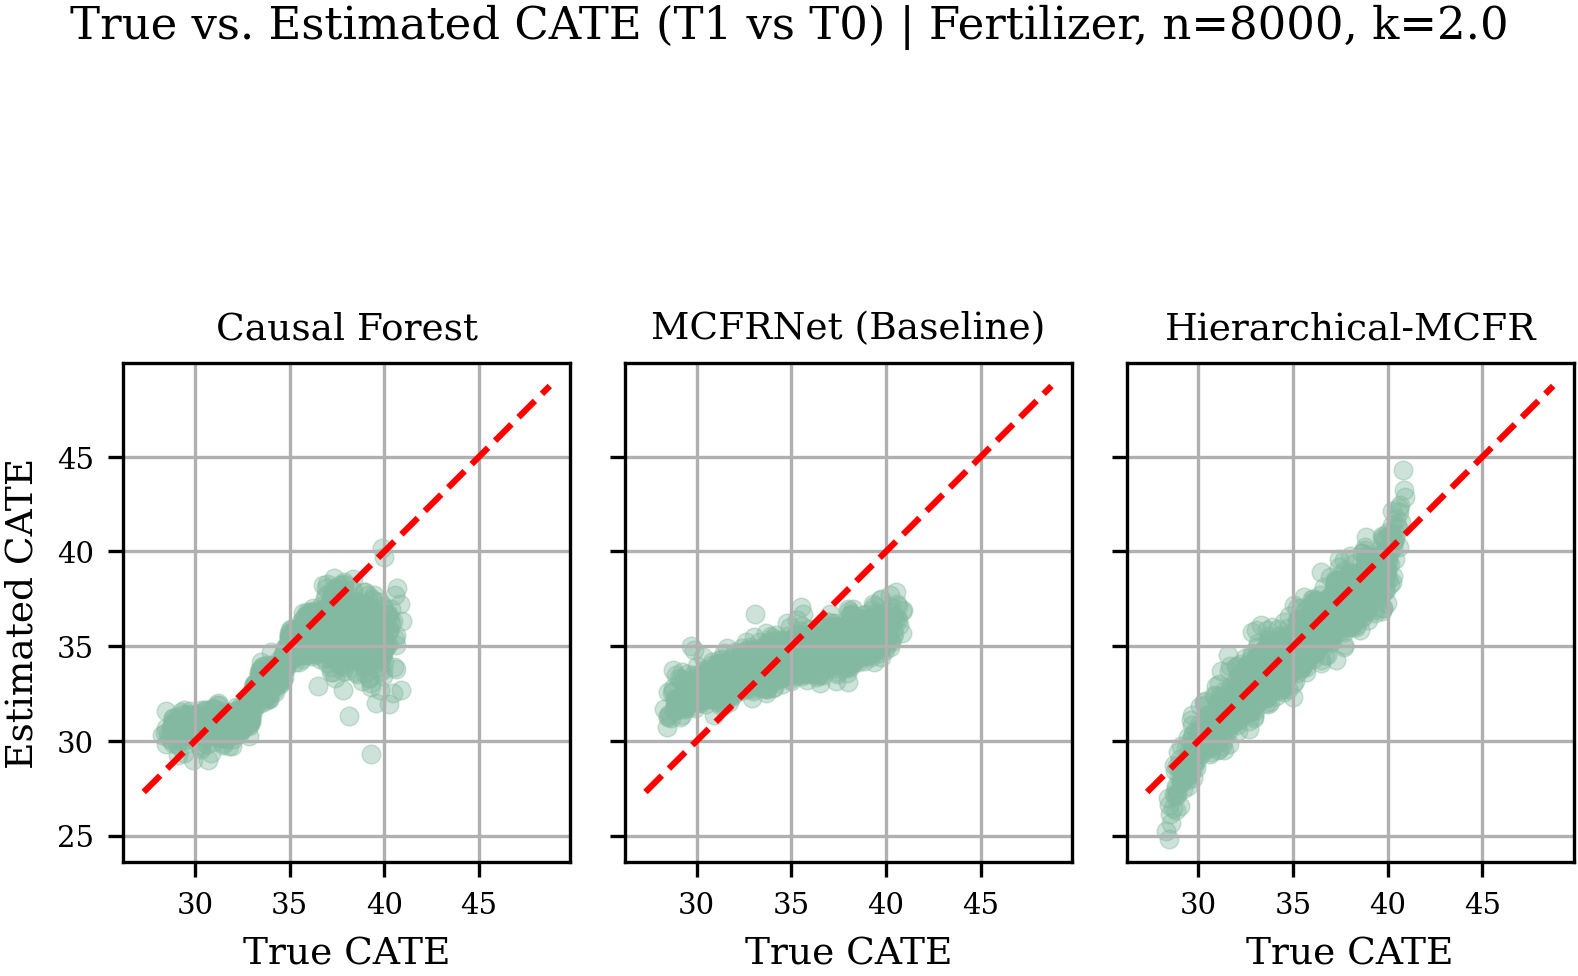

In [14]:
# Define the path to the specific timestamped run folder
RUN_FOLDER = "results/2025-09-16_23-06-46" # <-- Change this to your actual folder name

# Choose a specific experimental run to visualize from within that folder
plot_comparison_scatter(
    run_dir=RUN_FOLDER,
    scenario='fertilizer', 
    n_samples=8000, 
    kappa=2.0, 
    seed=118
) # 8000, 5.0, 117 interesting